# Meta-Learners Examples - Training, Estimation, Validation, Visualization

## Introduction
In this notebook, we will generate some synthetic data to demonstrate how to use the various Meta-Learner algorithms in order to estimate Individual Treatment Effects and Average Treatment Effects with confidence intervals.

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
os.chdir('../../../../')
os.getcwd()
import sys
sys.path
sys.path.append('/Users/mmandelbrod/workspace/causal_inference_matan/causalml/causalml')

In [4]:
!ls /Users/mmandelbrod/workspace/causal_inference_matan/causalml/causalml/inference/meta


__init__.py  drlearner.py rlearner.py  tlearner.py  utils.py
base.py      explainer.py slearner.py  tmle.py      xlearner.py


In [7]:
from causalml.inference.meta import LRSRegressor

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

Failed to import duecredit due to No module named 'duecredit'


In [3]:
import importlib
print(importlib.metadata.version('causalml') )

0.13.0


## Part A: Example Workflow using Synthetic Data

### Generate synthetic data
- We have implemented 4 modes of generating synthetic data (specified by input parameter `mode`). Refer to the References section for more detail on these data generation processes.

In [10]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

In [12]:
tau.mean()

0.5013571515076788

In [5]:

np.unique(treatment)

array([0, 1])

In [6]:
e

array([0.20251582, 0.39565089, 0.64131814, ..., 0.88432098, 0.9       ,
       0.62280229])

In [6]:
y

array([ 2.734352  ,  0.75552403,  3.01426357, ...,  1.03060912,
        2.15662537, -0.10710433])

NameError: name 'tau' is not defined

### Calculate Average Treatment Effect (ATE)
A meta-learner can be instantiated by calling a base learner class and providing an sklearn/xgboost regressor class as input. Alternatively, we have provided some ready-to-use learners that have already inherited their respective base learner class capabilities. This is more abstracted and allows these tools to be quickly and readily usable.

In [7]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.7122195]), array([0.66446089]), array([0.7599781]))
ATE estimate: 0.712
ATE lower bound: 0.664
ATE upper bound: 0.760
(array([0.7122195]), array([0.66446089]), array([0.7599781]))
ATE estimate: 0.712
ATE lower bound: 0.664
ATE upper bound: 0.760


In [8]:
ate_s

(array([0.7122195]), array([0.66446089]), array([0.7599781]))

In [9]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.56493937]), array([0.54030029]), array([0.58957845]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.56493937]), array([0.54030029]), array([0.58957845]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.70261663]), array([0.66247638]), array([0.74275688]))


In [10]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.54053437]), array([0.51880138]), array([0.56226736]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.70261663]), array([0.66247638]), array([0.74275688]))


In [11]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

Using the BaseXRegressor class and using XGB without propensity score input:
(array([0.5407985]), array([0.51906979]), array([0.5625272]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.70261663]), array([0.66247638]), array([0.74275688]))


In [12]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.57217873]), array([0.57171579]), array([0.57264167]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.53186292]), array([0.53145436]), array([0.53227149]))


In [14]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

Using the BaseRRegressor class and using XGB without propensity score input:
(array([0.54899103]), array([0.54852991]), array([0.54945216]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([0.59827751]), array([0.59786914]), array([0.59868588]))


### 7. Calculate Individual Treatment Effect (ITE/CATE)
CATE stands for Conditional Average Treatment Effect.

In [15]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

In [16]:
len(X)

10000

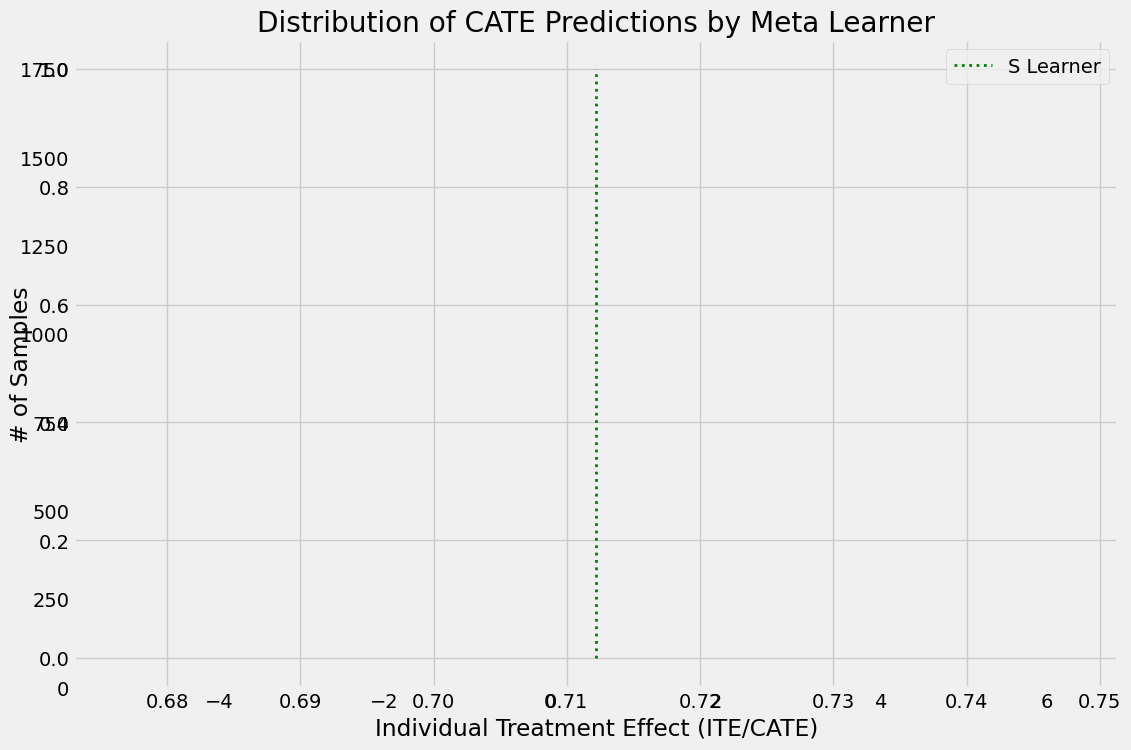

In [19]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

In [13]:
# R Learner with propensity score input and random sample weight
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
sample_weight = np.random.randint(1, 3, len(y))
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e, sample_weight=sample_weight)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.53792048]), array([0.53745095]), array([0.53839001]))


## Part B: Validating Meta-Learner Accuracy

We will validate the meta-learners' performance based on the same synthetic data generation method in Part A (`simulate_nuisance_and_easy_treatment`).

In [20]:
train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

In [21]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.367549,0.076344,3.726385
S Learner (XGB),0.104290,0.100497,0.299430
T Learner (LR),0.348419,0.035203,0.313720
T Learner (XGB),0.095834,0.591643,1.004462
X Learner (LR),0.348419,0.035203,0.313720
X Learner (XGB),0.076580,0.272519,0.611048
R Learner (LR),0.293115,0.035063,0.299513
R Learner (XGB),0.123620,0.815117,1.083159


In [22]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.370474,0.076479,3.835454
S Learner (XGB),0.103993,0.092931,0.310541
T Learner (LR),0.349389,0.035239,0.340656
T Learner (XGB),0.112129,0.381295,0.811073
X Learner (LR),0.349389,0.035239,0.340656
X Learner (XGB),0.087469,0.198775,0.476172
R Learner (LR),0.293747,0.034953,0.321343
R Learner (XGB),0.137508,0.543505,0.899899


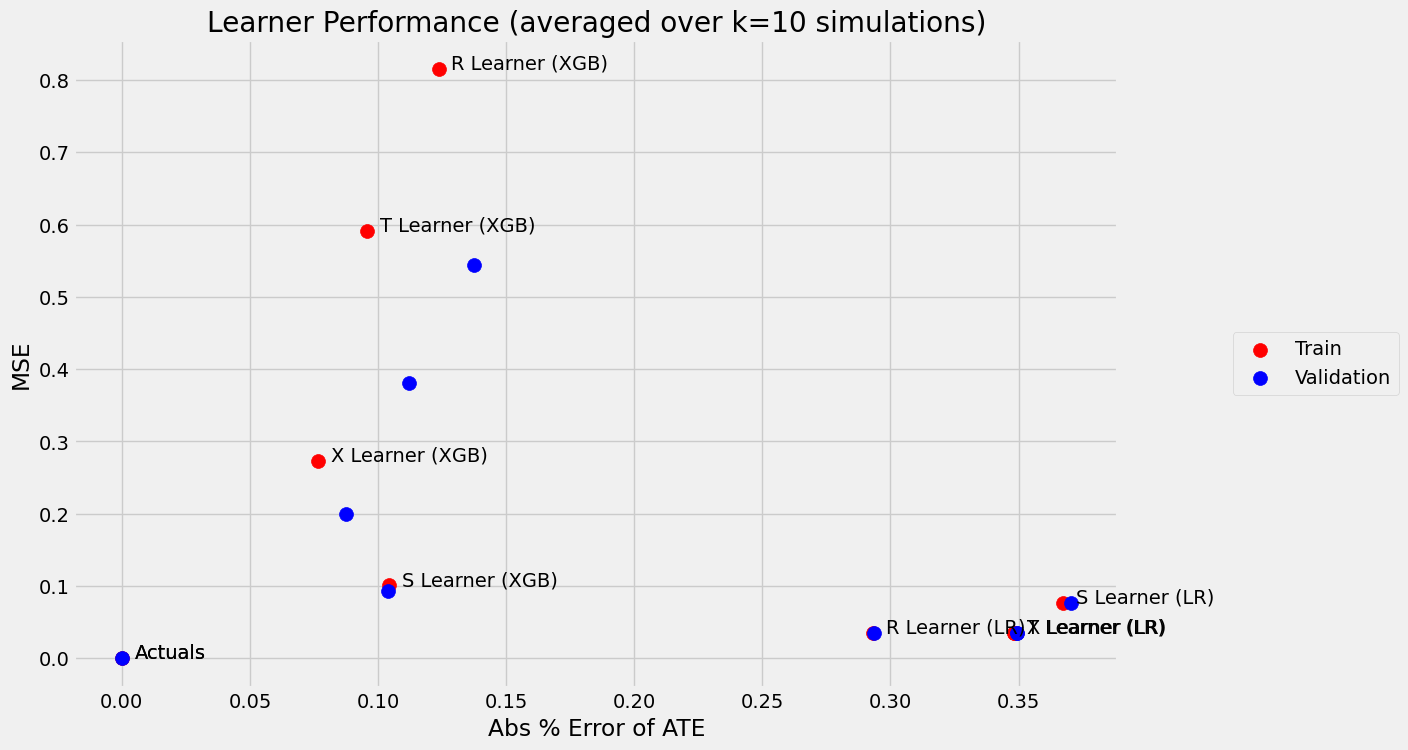

In [23]:
scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])

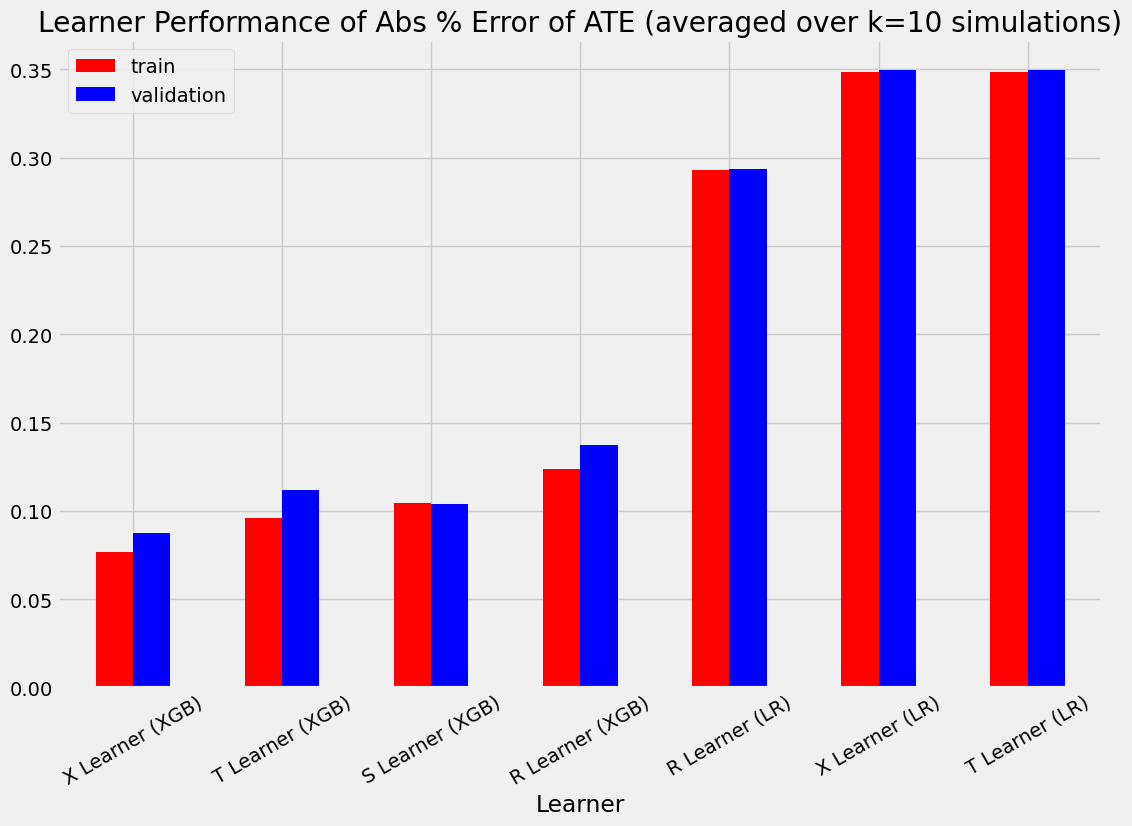

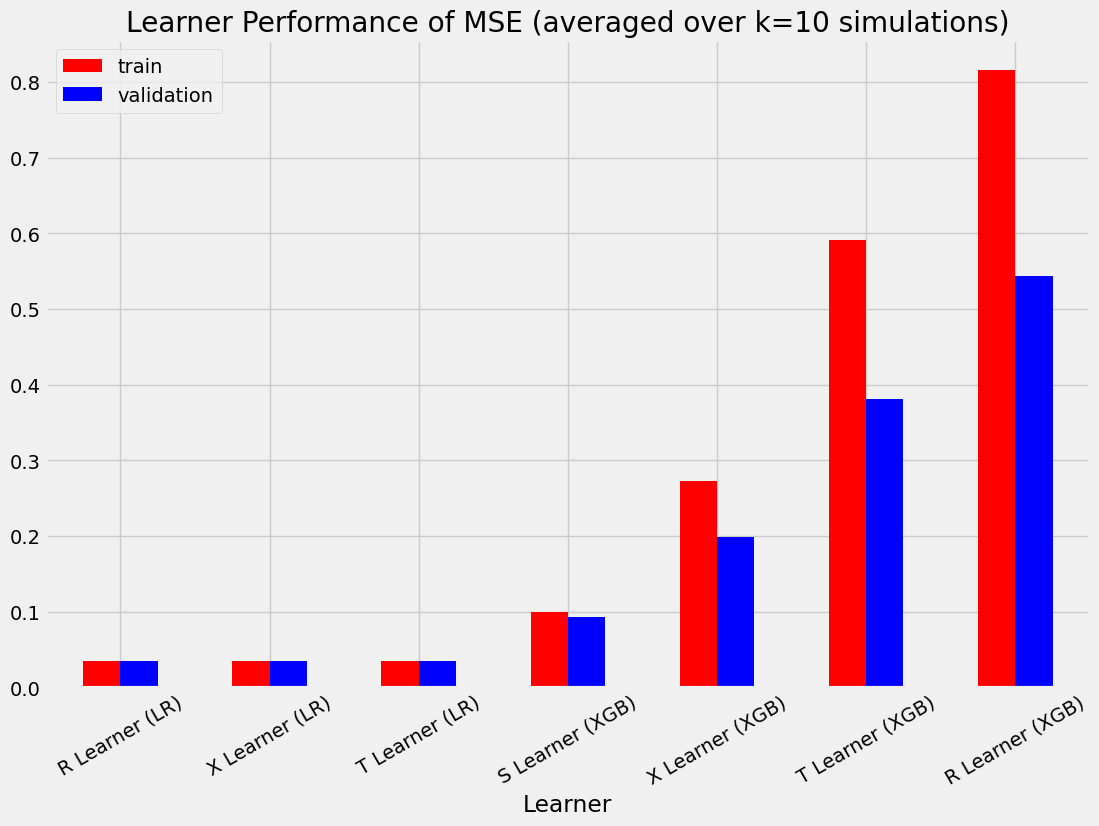

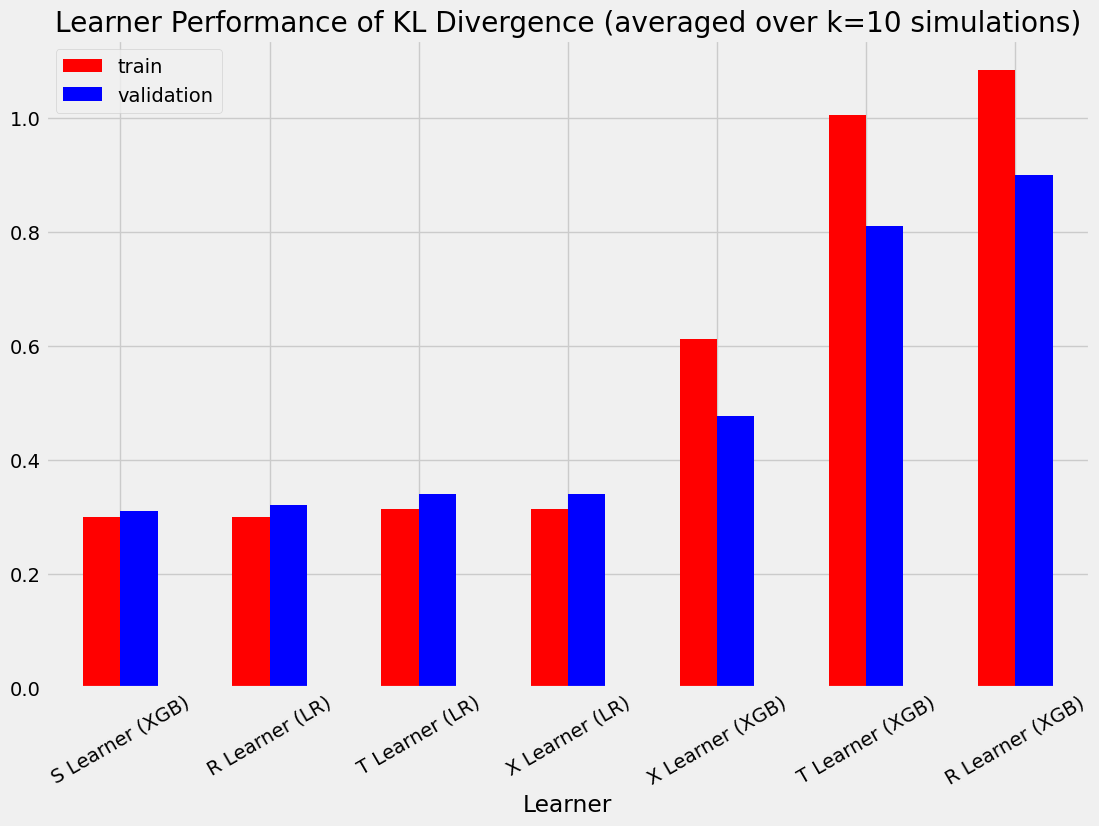

In [24]:
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])

In [39]:
# Single simulation
train_preds, valid_preds = get_synthetic_preds_holdout(simulate_nuisance_and_easy_treatment,
                                                       n=50000,
                                                       valid_size=0.2)

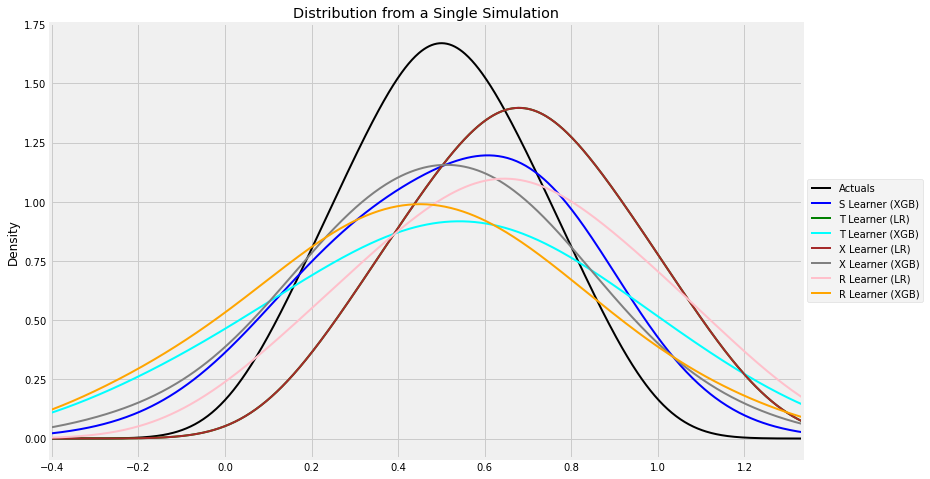

In [ ]:
#distribution plot for signle simulation of Training
distr_plot_single_sim(train_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)',' S Learner (XGB)'])

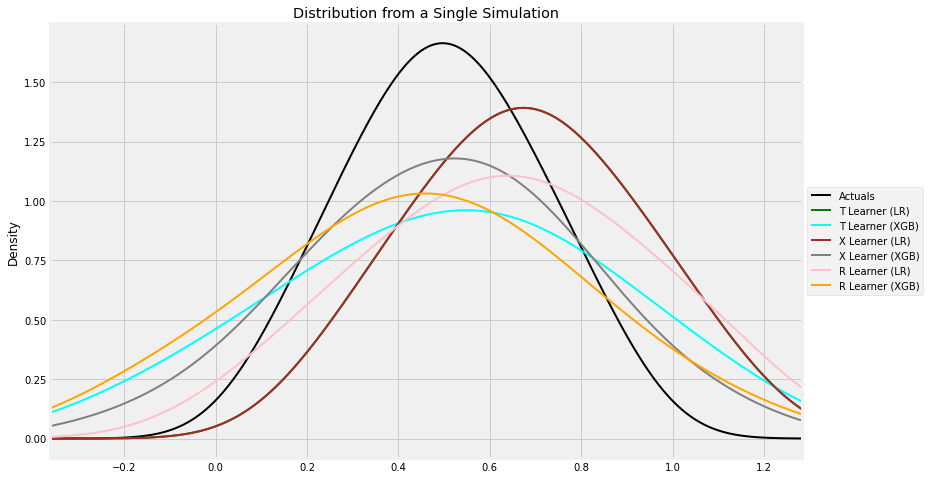

In [ ]:
#distribution plot for signle simulation of Validaiton
distr_plot_single_sim(valid_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)', 'S Learner (XGB)'])

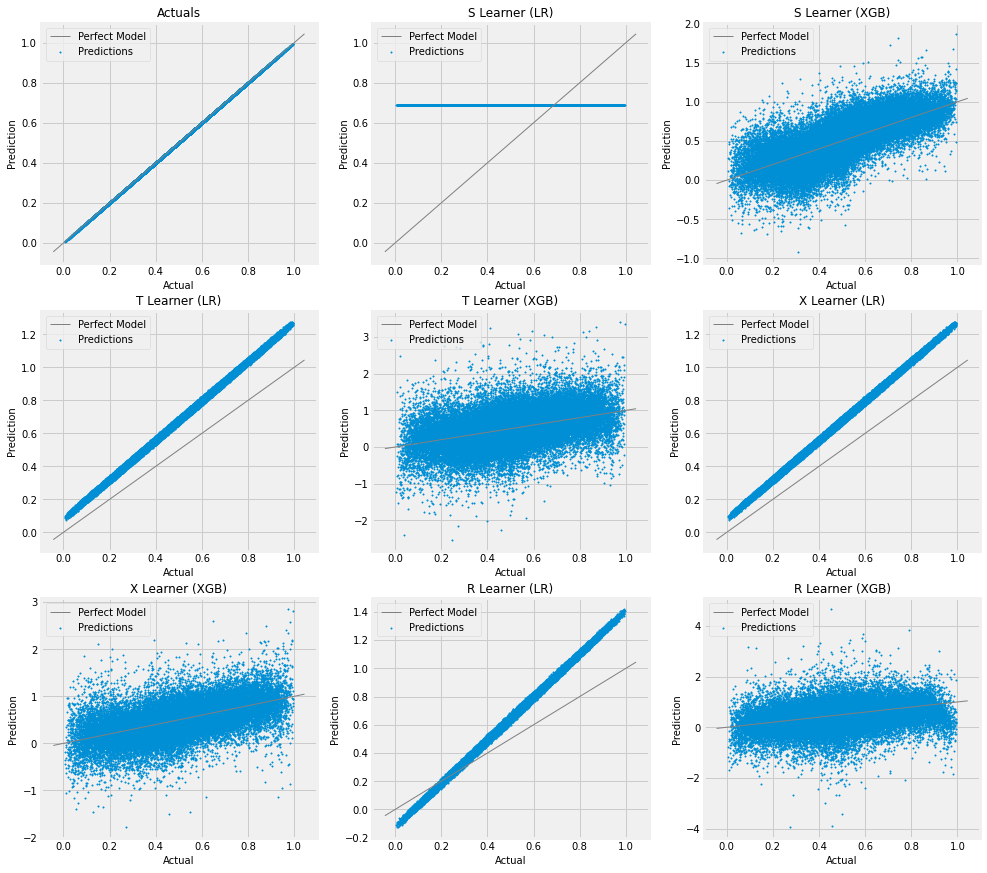

In [ ]:
# Scatter Plots for a Single Simulation of Training Data
scatter_plot_single_sim(train_preds)

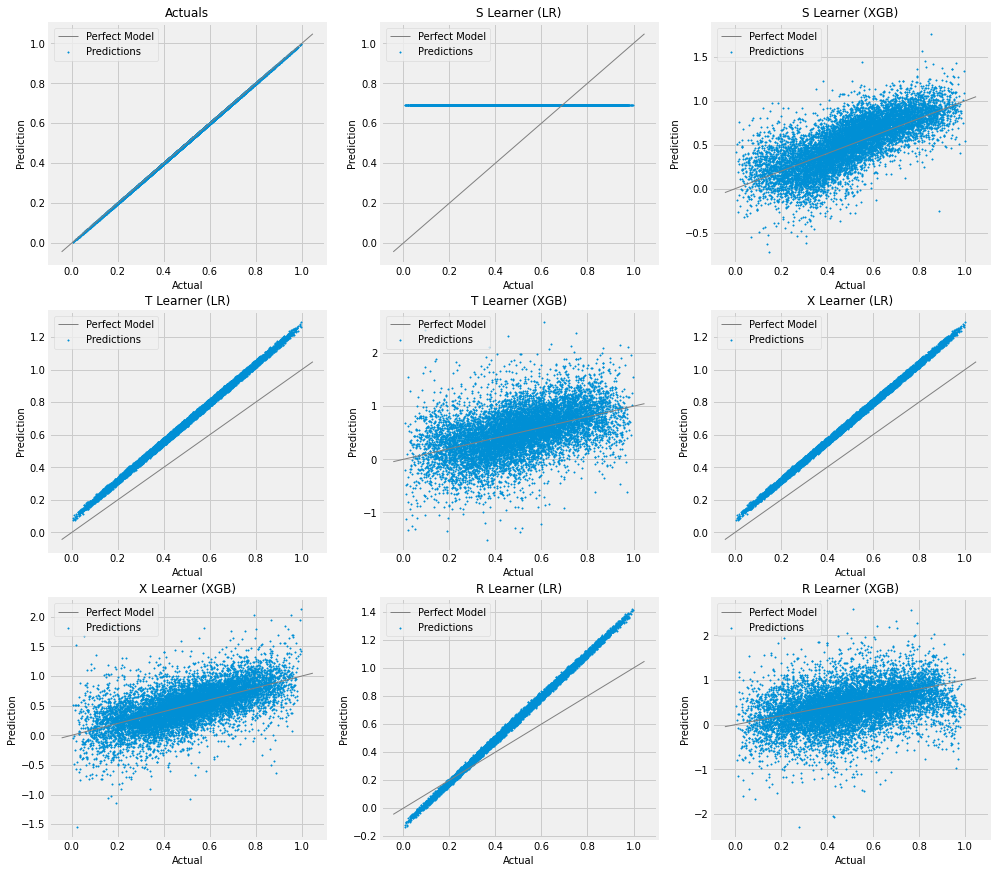

In [ ]:
# Scatter Plots for a Single Simulation of Validaiton Data
scatter_plot_single_sim(valid_preds)

In [41]:
train_preds

{'Actuals': array([0.71553568, 0.55362172, 0.6594206 , ..., 0.58883304, 0.47162247,
        0.70205749]),
 'generated_data': {'y': array([ 3.59133911,  2.37534091,  1.4657695 , ..., -0.12091983,
          1.02488937,  1.49201078]),
  'X': array([[0.91562071, 0.51545065, 0.82189743, 0.61225356, 0.98231817],
         [0.35728525, 0.74995818, 0.95853527, 0.44342702, 0.59090983],
         [0.32075297, 0.99808824, 0.52839267, 0.55670638, 0.04047358],
         ...,
         [0.38720795, 0.79045814, 0.18477919, 0.60186544, 0.64219368],
         [0.12731044, 0.8159345 , 0.0130924 , 0.43232076, 0.98215279],
         [0.72788183, 0.67623314, 0.28218131, 0.79138756, 0.37390872]]),
  'w': array([1, 1, 1, ..., 1, 0, 1]),
  'tau': array([0.71553568, 0.55362172, 0.6594206 , ..., 0.58883304, 0.47162247,
         0.70205749]),
  'b': array([2.30677037, 1.90522555, 1.42311857, ..., 1.94177157, 1.71813273,
         2.07293303]),
  'e': array([0.9       , 0.74583443, 0.84456311, ..., 0.82008098, 0.3205775

In [28]:
train_preds.keys()

dict_keys(['Actuals', 'generated_data', 'S Learner (LR)', 'S Learner (XGB)', 'T Learner (LR)', 'T Learner (XGB)', 'X Learner (LR)', 'X Learner (XGB)', 'R Learner (LR)', 'R Learner (XGB)'])

In [30]:
train_preds['Actuals']

array([0.28994346, 0.38478376, 0.16682427, ..., 0.85844668, 0.10117385,
       0.56060775])

In [29]:
train_preds['generated_data']


{'y': array([-0.99830412,  1.86001164,  1.39169064, ...,  1.81722823,
         0.7401525 ,  3.87927985]),
 'X': array([[0.09107165, 0.48881528, 0.43738019, 0.17093146, 0.11369591],
        [0.5330564 , 0.23651112, 0.59953666, 0.75339983, 0.6715152 ],
        [0.25316659, 0.08048195, 0.83127108, 0.67999826, 0.29532169],
        ...,
        [0.7716374 , 0.94525597, 0.43186255, 0.3287866 , 0.75723263],
        [0.03889933, 0.16344837, 0.35498526, 0.59406294, 0.16747975],
        [0.30524863, 0.81596688, 0.30241701, 0.64943531, 0.00688588]]),
 'w': array([1, 1, 0, ..., 1, 0, 1]),
 'tau': array([0.28994346, 0.38478376, 0.16682427, ..., 0.85844668, 0.10117385,
        0.56060775]),
 'b': array([0.37502138, 1.49477032, 1.11110748, ..., 1.46805528, 0.73983438,
        1.43600033]),
 'e': array([0.13939949, 0.3857978 , 0.1       , ..., 0.75136694, 0.1       ,
        0.705044  ])}

In [45]:
train_preds['X Learner (XGB)'].shape

(40000,)

In [38]:
train_preds['generated_data']

{'y': array([-0.99830412,  1.86001164,  1.39169064, ...,  1.81722823,
         0.7401525 ,  3.87927985]),
 'X': array([[0.09107165, 0.48881528, 0.43738019, 0.17093146, 0.11369591],
        [0.5330564 , 0.23651112, 0.59953666, 0.75339983, 0.6715152 ],
        [0.25316659, 0.08048195, 0.83127108, 0.67999826, 0.29532169],
        ...,
        [0.7716374 , 0.94525597, 0.43186255, 0.3287866 , 0.75723263],
        [0.03889933, 0.16344837, 0.35498526, 0.59406294, 0.16747975],
        [0.30524863, 0.81596688, 0.30241701, 0.64943531, 0.00688588]]),
 'w': array([1, 1, 0, ..., 1, 0, 1]),
 'b': array([0.37502138, 1.49477032, 1.11110748, ..., 1.46805528, 0.73983438,
        1.43600033]),
 'e': array([0.13939949, 0.3857978 , 0.1       , ..., 0.75136694, 0.1       ,
        0.705044  ])}

In [43]:
import copy

train_preds_degen = copy.deepcopy(train_preds)
del(train_preds_degen['Actuals'])
del (train_preds_degen['generated_data']['tau'])
del (train_preds_degen['generated_data']['b'])
del (train_preds_degen['generated_data']['e'])
train_preds_degen

{'generated_data': {'y': array([ 3.59133911,  2.37534091,  1.4657695 , ..., -0.12091983,
          1.02488937,  1.49201078]),
  'X': array([[0.91562071, 0.51545065, 0.82189743, 0.61225356, 0.98231817],
         [0.35728525, 0.74995818, 0.95853527, 0.44342702, 0.59090983],
         [0.32075297, 0.99808824, 0.52839267, 0.55670638, 0.04047358],
         ...,
         [0.38720795, 0.79045814, 0.18477919, 0.60186544, 0.64219368],
         [0.12731044, 0.8159345 , 0.0130924 , 0.43232076, 0.98215279],
         [0.72788183, 0.67623314, 0.28218131, 0.79138756, 0.37390872]]),
  'w': array([1, 1, 1, ..., 1, 0, 1])},
 'S Learner (LR)': array([0.70008268, 0.70008268, 0.70008268, ..., 0.70008268, 0.70008268,
        0.70008268]),
 'S Learner (XGB)': array([0.65309834, 0.2190516 , 0.49550867, ..., 0.47079635, 0.82187438,
        0.77630842]),
 'T Learner (LR)': array([0.95877943, 0.76426699, 0.88371485, ..., 0.80705893, 0.6815196 ,
        0.92678137]),
 'T Learner (XGB)': array([0.99177563, 0.164656

In [33]:
train_preds_degen.keys()

dict_keys(['generated_data', 'S Learner (LR)', 'S Learner (XGB)', 'T Learner (LR)', 'T Learner (XGB)', 'X Learner (LR)', 'X Learner (XGB)', 'R Learner (LR)', 'R Learner (XGB)'])

,Learner,cum_gain_auuc
2,T Learner (XGB),1.149705e+07
6,R Learner (XGB),1.104569e+07
4,X Learner (XGB),1.006840e+07
0,S Learner (XGB),8.858968e+06
7,Random,7.338721e+06
1,T Learner (LR),7.298322e+06
3,X Learner (LR),7.298322e+06
5,R Learner (LR),7.284578e+06


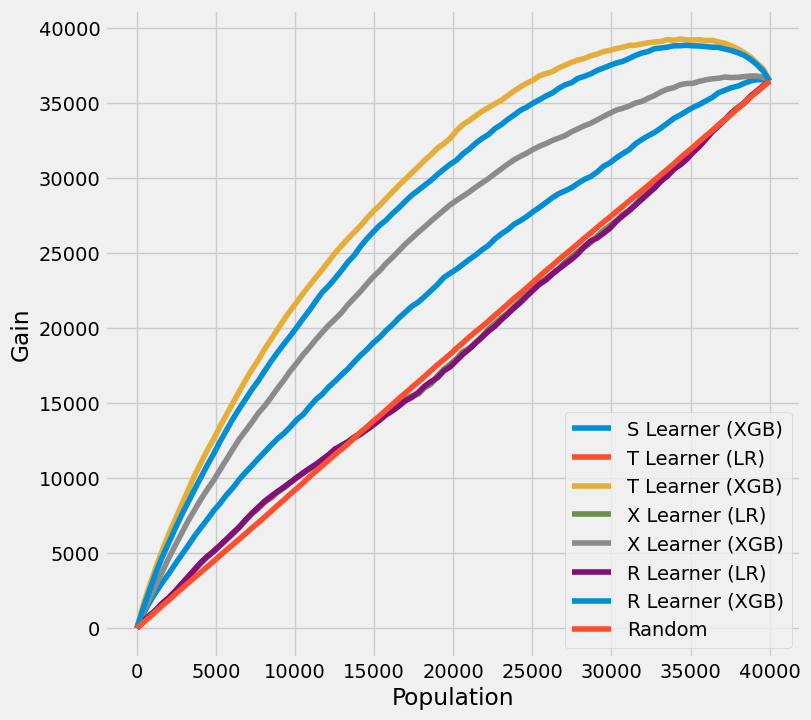

In [44]:
get_synthetic_auuc(train_preds_degen, drop_learners=['S Learner (LR)'])

,Learner,cum_gain_auuc
0,Actuals,4.933005e+06
6,R Learner (LR),4.932072e+06
2,T Learner (LR),4.931386e+06
4,X Learner (LR),4.931386e+06
1,S Learner (XGB),4.698793e+06
5,X Learner (XGB),4.572728e+06
3,T Learner (XGB),4.449406e+06
7,R Learner (XGB),4.368778e+06
8,Random,4.000085e+06


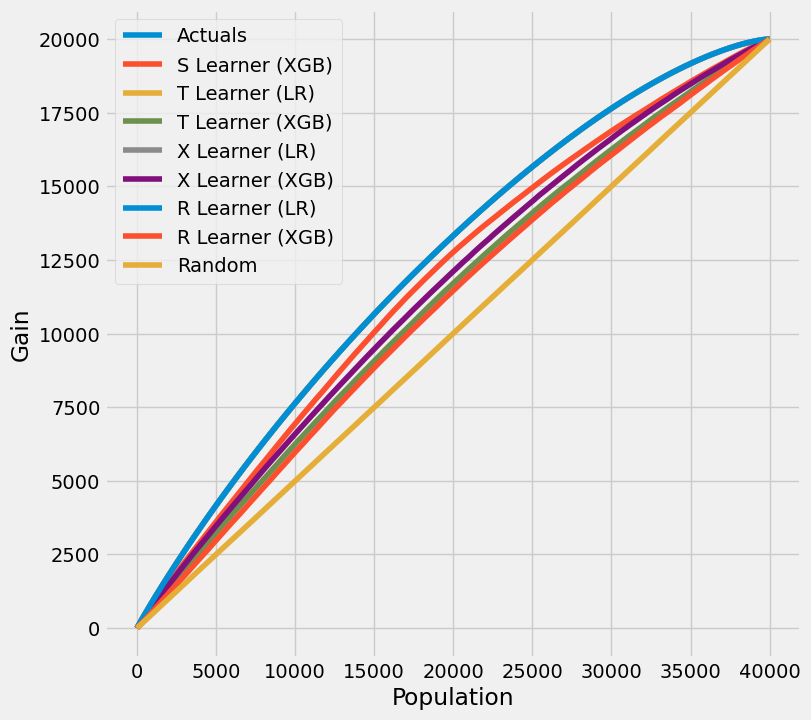

In [31]:
# Cumulative Gain AUUC values for a Single Simulation of Training Data
get_synthetic_auuc(train_preds, drop_learners=['S Learner (LR)'])

,Learner,cum_gain_auuc
0,Actuals,307775.080438
6,R Learner (LR),307717.572474
2,T Learner (LR),307714.491455
4,X Learner (LR),307714.491455
1,S Learner (XGB),294010.684983
5,X Learner (XGB),287004.166278
3,T Learner (XGB),278805.039500
7,R Learner (XGB),273805.130449
8,Random,249636.204131


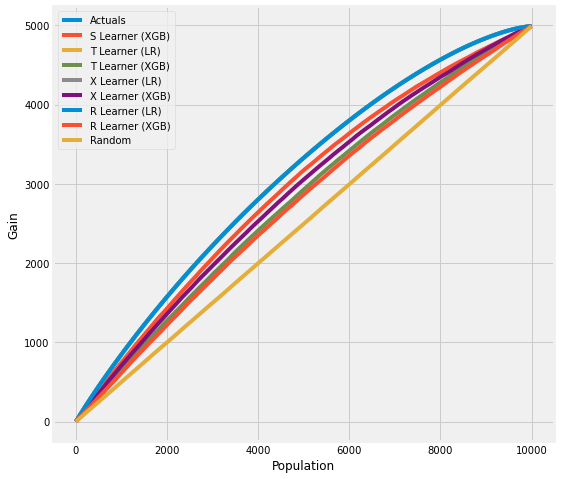

In [ ]:
get_synthetic_auuc(valid_preds, drop_learners=['S Learner (LR)'])
# Cumulative Gain AUUC values for a Single Simulation of Validaiton Data

# Synthetic - RCT 

In [35]:
# Generate synthetic data using mode 2
y, X, treatment, tau, b, e = synthetic_data(mode=2, n=10000, p=8, sigma=1.0)
actual_ate = tau.mean()
actual_ate

0.8114870150425448

(array([  0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,   2.,
          1.,   4.,   6.,   5.,   9.,  10.,  10.,   7.,  13.,  14.,  19.,
         25.,  33.,  33.,  35.,  66.,  62.,  71.,  99., 102., 124., 133.,
        161., 185., 187., 230., 239., 258., 264., 267., 288., 316., 340.,
        350., 334., 370., 328., 342., 360., 344., 366., 313., 285., 307.,
        293., 239., 225., 227., 196., 168., 158., 175., 134., 128., 118.,
         90.,  95.,  68.,  60.,  48.,  52.,  45.,  37.,  19.,  12.,  19.,
         13.,   9.,  13.,   8.,   7.,   8.,   6.]),
 array([-4.00000000e+00, -3.90000000e+00, -3.80000000e+00, -3.70000000e+00,
        -3.60000000e+00, -3.50000000e+00, -3.40000000e+00, -3.30000000e+00,
        -3.20000000e+00, -3.10000000e+00, -3.00000000e+00, -2.90000000e+00,
        -2.80000000e+00, -2.70000000e+00, -2.60000000e+00, -2.50000000e+00,
        -2.40000000e+00, -2.30000000e+00, -2.20000000e+00, -2.10000000e+00,
        -2.00000000e+00, -1.90000000e+00, -1.80000

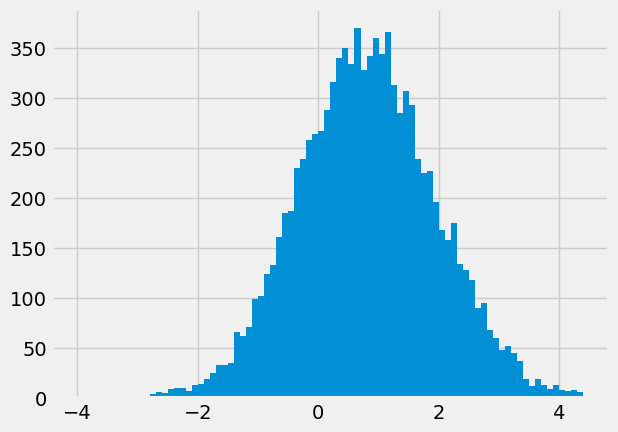

In [41]:
plt.hist(tau, bins = np.arange(-4, 4.5, 0.1))

In [36]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.80563731]), array([0.75793628]), array([0.85333835]))
ATE estimate: 0.806
ATE lower bound: 0.758
ATE upper bound: 0.853
(array([0.80563731]), array([0.75793628]), array([0.85333835]))
ATE estimate: 0.806
ATE lower bound: 0.758
ATE upper bound: 0.853


In [37]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.80907004]), array([0.77623871]), array([0.84190137]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.80907004]), array([0.77623871]), array([0.84190137]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.80537091]), array([0.75769306]), array([0.85304876]))


In [38]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.8076414]), array([0.77690717]), array([0.83837562]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.80537091]), array([0.75769306]), array([0.85304876]))


# Synthetic - classification (RCT)

In [66]:
# from dataset.classification import make_uplift_classification

# Define the parameters
n_samples = 50000  # Number of samples
treatment_name = ["control", "treatment"]  # Treatment groups
n_classification_features = 8  # Number of features
n_classification_informative = 5  # Number of informative features
n_uplift_increase_dict = {"treatment": 2}  # Number of features for generating positive treatment effects
delta_uplift_increase_dict = {"treatment": 0.02}  # Positive treatment effect created by the positive uplift features
n_uplift_increase_mix_informative_dict = {"treatment": 1}  # Number of positive mix features for each treatment

# Generate the synthetic dataset
df, x_name = make_uplift_classification(
    n_samples=n_samples,
    treatment_name=treatment_name,
    n_classification_features=n_classification_features,
    n_classification_informative=n_classification_informative,
    n_uplift_increase_dict=n_uplift_increase_dict,
    delta_uplift_increase_dict=delta_uplift_increase_dict,
    n_uplift_increase_mix_informative_dict=n_uplift_increase_mix_informative_dict,
)

# Print the first few rows of the dataset
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_uplift_increase,x10_uplift_increase,x11_increase_mix,conversion,treatment_effect
0,control,0.233999,1.032667,2.282647,-0.420836,-1.305762,1.035622,0.066518,-1.272312,1.346445,-0.913293,-1.120800,0,0
1,treatment,0.740229,-1.512444,1.131405,1.925542,1.466043,-0.309887,1.156447,1.744459,0.967502,1.175484,0.923328,0,0
2,control,1.111702,-1.959892,1.525061,-1.182298,0.547104,0.564658,1.601054,1.421036,2.373741,-1.683813,0.072572,0,0
3,control,-0.213877,-2.498807,0.360203,-1.172889,-0.601276,-1.357479,-1.224662,0.500011,1.422965,-1.001881,-0.624619,0,0
4,treatment,0.346080,0.550301,1.308705,1.244902,0.755968,-0.516739,0.545227,0.020747,0.689951,1.228616,0.450296,0,0


In [67]:
df[df['treatment_effect'] > 0]


,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_uplift_increase,x10_uplift_increase,x11_increase_mix,conversion,treatment_effect
15,treatment,-0.791504,1.989733,1.191288,0.075026,1.344412,0.383744,-0.778170,-0.236784,-0.592260,-0.785410,1.046666,1,1
282,treatment,0.405180,0.168275,1.295282,-1.726856,0.726294,-0.239436,1.896547,0.517281,-1.794655,-0.759591,0.764737,1,1
406,treatment,1.281648,-2.596363,1.206309,1.667333,-0.806345,-0.739343,-1.870357,0.019519,2.555170,-2.647726,-0.925072,1,1
419,treatment,-0.697052,-0.705153,1.099025,-0.874019,-0.760118,-0.000957,-1.054452,0.170413,0.380915,-1.694596,-0.598000,1,1
452,treatment,-2.483679,-5.158569,-1.715144,-0.886655,0.384458,1.417184,1.066604,-0.035298,-0.698239,-0.759083,0.370786,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99653,treatment,-0.230004,-7.231808,-1.620885,-0.860990,-1.622130,-1.597812,0.402946,-1.536105,-1.384601,-1.133532,-0.979186,1,1
99660,treatment,1.239182,-0.289082,2.198853,-0.908685,-1.050567,0.072672,-0.606336,2.317790,0.429617,-1.288903,-0.813413,1,1
99689,treatment,0.085208,-1.082461,2.175993,-0.248776,0.436917,1.057951,-0.163448,0.166913,-2.585749,-1.339354,0.663587,1,1
99722,treatment,0.620335,-0.215155,1.446079,1.115506,-0.801123,1.786229,-1.208632,1.142324,0.160401,-1.412080,-0.597681,1,1


In [68]:
(df['treatment_group_key'] == 'control').sum()/len(df)

0.5

In [69]:
empirical_uplift = df[df['treatment_group_key'] == 'treatment']['conversion'].mean() - df[df['treatment_group_key'] == 'control']['conversion'].mean()
empirical_uplift

0.018819999999999948

In [70]:
x_name

['x1_informative',
 'x2_informative',
 'x3_informative',
 'x4_informative',
 'x5_informative',
 'x6_irrelevant',
 'x7_irrelevant',
 'x8_irrelevant',
 'x9_uplift_increase',
 'x10_uplift_increase',
 'x11_increase_mix']

In [71]:
df['treatment_group_key_numeric'] = (df['treatment_group_key'] == 'treatment').astype(int)
df

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_uplift_increase,x10_uplift_increase,x11_increase_mix,conversion,treatment_effect,treatment_group_key_numeric
0,control,0.233999,1.032667,2.282647,-0.420836,-1.305762,1.035622,0.066518,-1.272312,1.346445,-0.913293,-1.120800,0,0,0
1,treatment,0.740229,-1.512444,1.131405,1.925542,1.466043,-0.309887,1.156447,1.744459,0.967502,1.175484,0.923328,0,0,1
2,control,1.111702,-1.959892,1.525061,-1.182298,0.547104,0.564658,1.601054,1.421036,2.373741,-1.683813,0.072572,0,0,0
3,control,-0.213877,-2.498807,0.360203,-1.172889,-0.601276,-1.357479,-1.224662,0.500011,1.422965,-1.001881,-0.624619,0,0,0
4,treatment,0.346080,0.550301,1.308705,1.244902,0.755968,-0.516739,0.545227,0.020747,0.689951,1.228616,0.450296,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,control,1.318054,-2.646616,-2.863677,-0.612522,-1.083188,0.424501,-0.467392,0.569430,0.833176,2.356903,-0.891406,1,0,0
99996,treatment,2.052922,-0.742214,-0.979766,0.910453,0.721486,1.257258,-1.162696,0.821184,-0.019861,2.623485,0.521429,1,0,1
99997,control,0.226006,-1.169776,-2.198829,1.164852,0.508177,-0.313589,1.331156,1.080643,1.320667,0.355509,0.186899,1,0,0
99998,control,-1.932695,-2.194788,-0.243614,-1.316865,-0.302705,-1.270526,0.071911,0.252024,2.594533,-1.225090,-0.568276,0,0,0


In [72]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=df[x_name], treatment=df['treatment_group_key_numeric'], y=df['conversion'])
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# # After calling estimate_ate, add pretrain=True flag to skip training
# # This flag is applicable for other meta learner
# ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
# print(ate_s)
# print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
# print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
# print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.01906264]), array([0.0143898]), array([0.02373548]))
ATE estimate: 0.019
ATE lower bound: 0.014
ATE upper bound: 0.024


In [76]:
feature_importances = learner_s.model.feature_importances_

# Print feature importances
for i, importance in enumerate(feature_importances):
    print(f"Feature {i}: {importance}")

AttributeError: 'StatsmodelsOLS' object has no attribute 'feature_importances_'

In [74]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=df[x_name], treatment=df['treatment_group_key_numeric'], y=df['conversion'])
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=df[x_name], treatment=df['treatment_group_key_numeric'], y=df['conversion'])
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=df[x_name], treatment=df['treatment_group_key_numeric'], y=df['conversion'])
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.01826201]), array([0.01455254]), array([0.02197148]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.01826201]), array([0.01455254]), array([0.02197148]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.01899819]), array([0.01432576]), array([0.02367063]))


In [77]:
feature_importances = learner_s.learner.model.feature_importances_

AttributeError: 'LRSRegressor' object has no attribute 'learner'

In [79]:
cate_s = learner_s.fit_predict(X=df[x_name], treatment=df['treatment_group_key_numeric'], y=df['conversion'])

In [80]:
cate_s

array([[0.01906264],
       [0.01906264],
       [0.01906264],
       ...,
       [0.01906264],
       [0.01906264],
       [0.01906264]])

In [81]:
cate_t = learner_t.fit_predict(X=df[x_name], treatment=df['treatment_group_key_numeric'], y=df['conversion'])

(array([0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 6.000e+00, 1.600e+01,
        3.400e+01, 7.700e+01, 1.570e+02, 3.100e+02, 5.220e+02, 8.690e+02,
        1.471e+03, 2.144e+03, 3.143e+03, 4.331e+03, 5.569e+03, 6.767e+03,
        7.820e+03, 8.546e+03, 8.997e+03, 8.872e+03, 8.257e+03, 7.301e+03,
        6.063e+03, 4.650e+03, 3.570e+03, 2.506e+03, 1.666e+03, 1.110e+03,
        6.850e+02, 4.000e+02, 2.370e+02, 1.520e+02, 9.900e+01, 8.100e+01,
        6.900e+01, 7.100e+01, 6.500e+01, 9.400e+01, 1.040e+02, 8.200e+01,
        1.040e+02, 1.070e+02, 1.070e+02, 1.250e+02, 1.200e+02, 1.250e+02,
        1.210e+02, 1.230e+02, 1.300e+02, 1.300e+02, 1.280e+02, 1.300e+02,
        1.370e+02, 1.230e+02, 1.130e+02, 1.090e+02, 1.190e+02, 1.090e+02]),
 array([-2.00000000e-01, -1.90000000e-01, -1.80000000e-01, -1.70000000e-01,
        -1.60000000e-01, -1.50000000e-01, -1.40000000e-01, -1.30000000e-01,
        -1.20000000e-01, -1.10000000e-01, -1.00000000e-01, -9.00000000e-02,
        -8.00000000e-02, -7.00

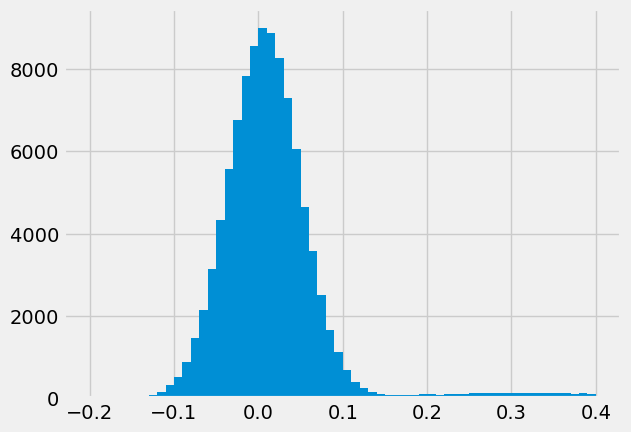

In [85]:
plt.hist(cate_t, bins = np.arange(-0.2, 0.4, 0.01))

In [86]:
cate_t.mean()

0.01899819327251896